#Cocacola Sales

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [3]:
data=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime, time

In [5]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [6]:
quarter_to_month = {
    "Q1": 1,
    "Q2": 4,
    "Q3": 7,
    "Q4": 10
}

def convert_to_datetime(Quarter):
    quarter, year = Quarter.split("_")
    month = quarter_to_month[quarter]
    year = int(year) + 1900
    return pd.Timestamp(year=year, month=month, day=1)

data['datetime'] = data['Quarter'].apply(convert_to_datetime)


#EDA

In [7]:
data.head()

,Quarter,Sales,datetime
0,Q1_86,1734.827000,1986-01-01
1,Q2_86,2244.960999,1986-04-01
2,Q3_86,2533.804993,1986-07-01
3,Q4_86,2154.962997,1986-10-01
4,Q1_87,1547.818996,1987-01-01


In [8]:
data.dtypes

Quarter             object
Sales              float64
datetime    datetime64[ns]
dtype: object

In [9]:
data.shape

(42, 3)

In [10]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Quarter   42 non-null     object        
 1   Sales     42 non-null     float64       
 2   datetime  42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ KB


In [13]:
data.isna().sum()

Quarter     0
Sales       0
datetime    0
dtype: int64

In [14]:
data.duplicated().sum()

0

In [15]:
data['Sales'].skew()

0.6301623195471511

In [16]:
data['quarter']=data['Quarter'].str.extract(r'Q(\d)').astype(str)
data['year']=data['Quarter'].str.extract(r'_(\d{2})').astype(str)

In [17]:
data.dtypes

Quarter             object
Sales              float64
datetime    datetime64[ns]
quarter             object
year                object
dtype: object

In [18]:
data.head()

,Quarter,Sales,datetime,quarter,year
0,Q1_86,1734.827000,1986-01-01,1,86
1,Q2_86,2244.960999,1986-04-01,2,86
2,Q3_86,2533.804993,1986-07-01,3,86
3,Q4_86,2154.962997,1986-10-01,4,86
4,Q1_87,1547.818996,1987-01-01,1,87


In [19]:
data.index=data.datetime

In [22]:
data.head(2)

,Quarter,Sales,datetime,quarter,year
datetime,,,,,
1986-01-01,Q1_86,1734.827000,1986-01-01,1,86
1986-04-01,Q2_86,2244.960999,1986-04-01,2,86


In [23]:
data['quarter'].unique()

array(['1', '2', '3', '4'], dtype=object)

<Axes: xlabel='datetime'>

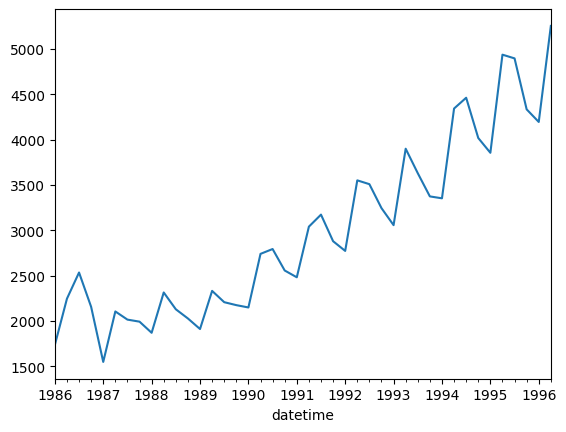

In [24]:
data['Sales'].plot()

<Axes: xlabel='quarter', ylabel='year'>

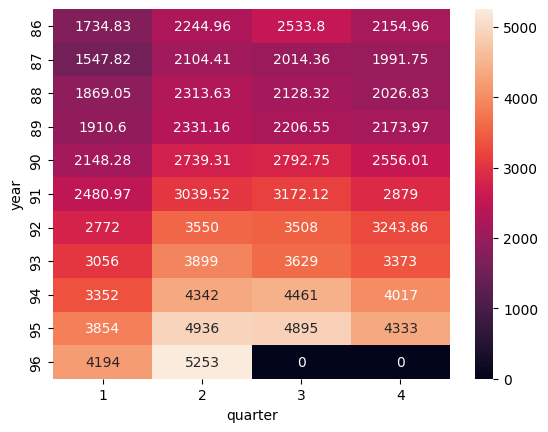

In [27]:
heatmap_y_Sales=data.pivot_table(index='year', columns='quarter', values='Sales', aggfunc='mean', fill_value=0)
sns.heatmap(heatmap_y_Sales, annot=True, fmt='g')

<Axes: xlabel='year', ylabel='Sales'>

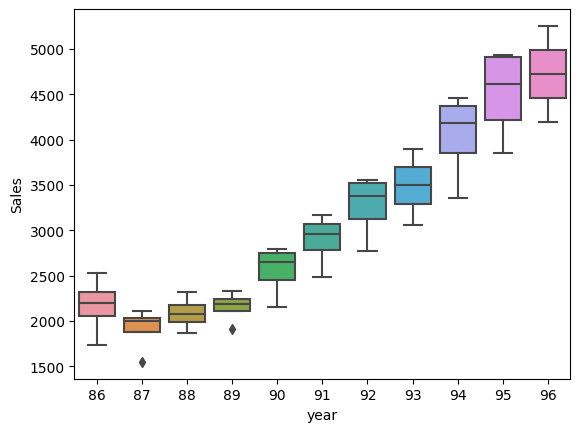

In [28]:
sns.boxplot(x='year', y='Sales', data=data)        #there is a upward trend in Sales

<Axes: xlabel='quarter', ylabel='Sales'>

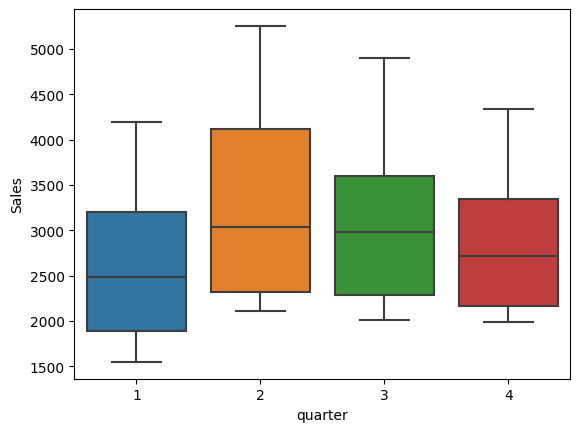

In [29]:
sns.boxplot(x='quarter', y='Sales', data=data)     #higher sales observed in 2nd and 3rd quartile

<Axes: xlabel='year', ylabel='Sales'>

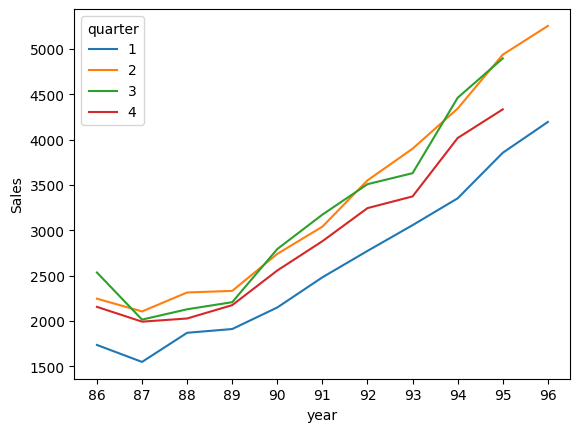

In [31]:
sns.lineplot(x='year', y='Sales', hue='quarter', data=data)

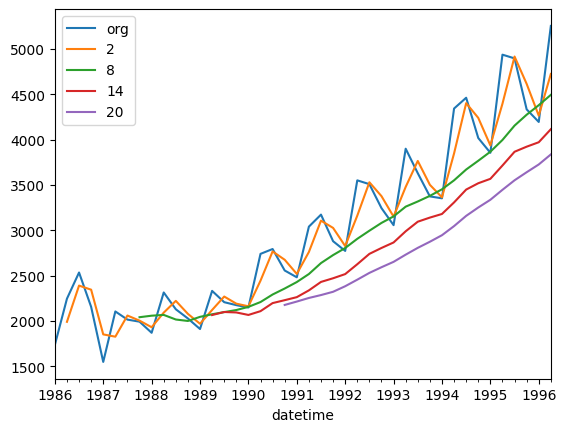

In [ ]:
#moving average for time series data
data['Sales'].plot(label='org')
for i in range(2,24,6):
  data['Sales'].rolling(i).mean().plot(label=str(i))

plt.legend(loc='best')                                      #lag 2 is important in forecasting

In [35]:
data.dtypes

Quarter             object
Sales              float64
datetime    datetime64[ns]
quarter             object
year                object
dtype: object

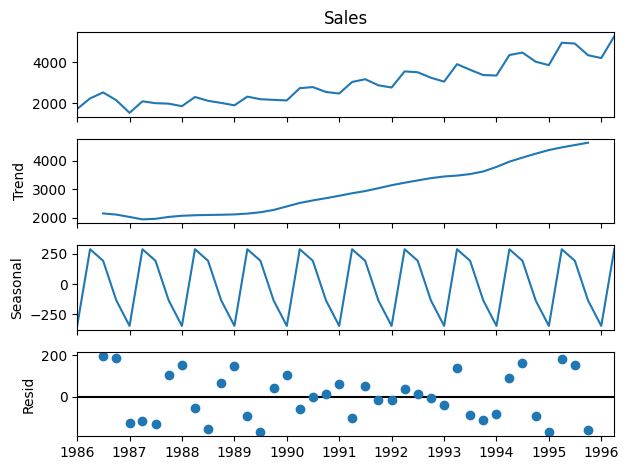

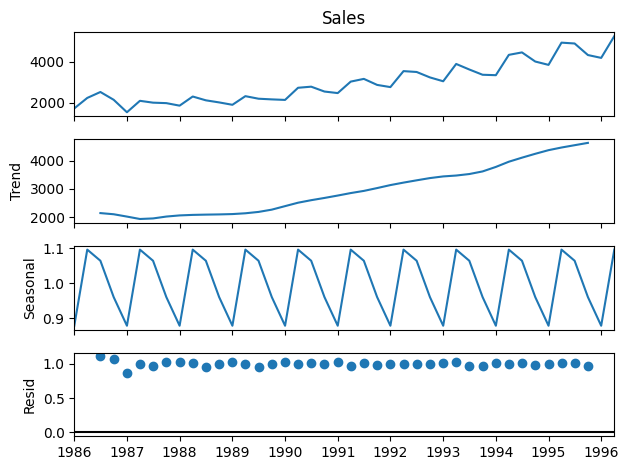

In [38]:
decompose_ts_add=seasonal_decompose(data['Sales'], model='additive')
decompose_ts_add.plot()
decompose_ts_mul=seasonal_decompose(data['Sales'], model='multiplicative')
decompose_ts_mul.plot()
plt.show();

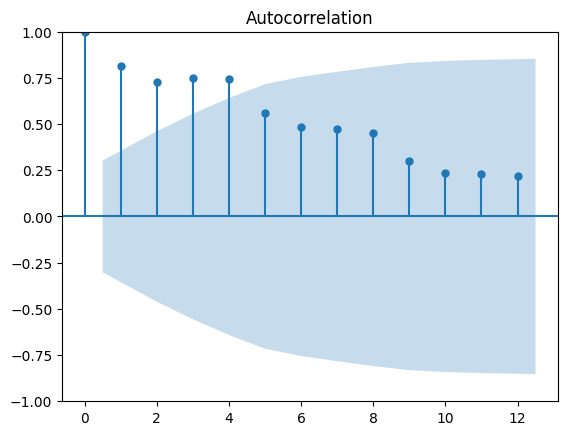

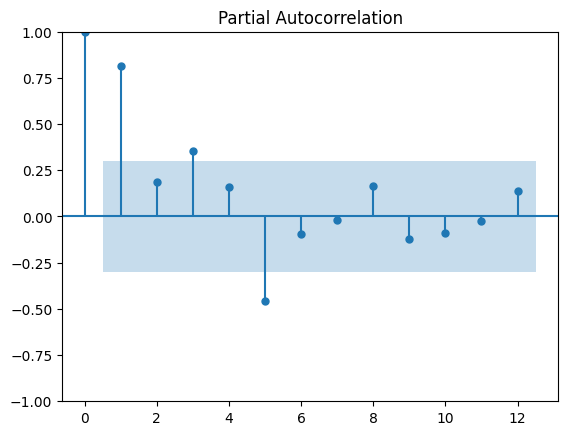

In [39]:
tsa_plots.plot_acf(data.Sales, lags=12)
plt.plot();
tsa_plots.plot_pacf(data.Sales, lags=12)
plt.plot();

In [41]:
Train=data.head(34)
Test=data.tail(8)

In [42]:
def RMSE(pred, org):
  error=np.sqrt(np.mean((pred-org)**2))
  return(error)

In [46]:
#simple exponential method
import warnings
warnings.filterwarnings('ignore')
ses_model=SimpleExpSmoothing(Train['Sales']).fit()
pred_ses=ses_model.predict(start=Test.index[0], end=Test.index[-1])
rmse_ses=RMSE(pred_ses, Test.Sales)
rmse_ses

786.8359863846738

In [47]:
#HOLT method
hw_model=Holt(Train['Sales']).fit()
pred_hw=hw_model.predict(start=Test.index[0], end=Test.index[-1])
rmse_hw=RMSE(pred_hw, Test.Sales)
rmse_hw

459.77565063357093

In [48]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add=ExponentialSmoothing(Train.Sales, seasonal='add', trend='add', seasonal_periods=4, damped=True).fit()
pred_hwe_add_add=hwe_model_add_add.predict(start=Test.index[0], end=Test.index[-1])
rmse_hwe_add_add=RMSE(pred_hwe_add_add, Test.Sales)
rmse_hwe_add_add

372.75420449401946

In [53]:
##Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend
hwe_model_mul_add=ExponentialSmoothing(Train.Sales, seasonal='mul', trend='mul', seasonal_periods=4).fit()
pred_hwe_mul_add=hwe_model_mul_add.predict(start=Test.index[0], end=Test.index[-1])
rmse_hwe_mul_add=RMSE(pred_hwe_mul_add, Test.Sales)
rmse_hwe_mul_add

129.07748186115933

In [54]:
#ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00


In [63]:
auto_arima_model=auto_arima(Train.Sales, start_p=0, start_q=0,
                              max_p=10, max_q=10,
                            m=4, start_P=0, seasonal=True, d=1, D=1,
                            trace=True,error_action="ignore",
                              suppress_warnings= True,
                              stepwise=False);

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=382.941, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=384.936, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=384.936, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=386.890, Time=0.21 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=384.771, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=386.725, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=386.712, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=387.910, Time=0

In [64]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log Likelihood                -190.471
Date:                           Fri, 03 Nov 2023   AIC                            382.941
Time:                                   09:56:50   BIC                            384.308
Sample:                               01-01-1986   HQIC                           383.369
                                    - 04-01-1994                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.962e+04   6300.277      4.701      0.000    1.73e+04     4.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.56
Prob(Q):                              0.73   Prob(JB):                         0.46
Heteroskedasticity (H):               0.36   Skew:                             0.35
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
pred_arima=auto_arima_model.predict(start=Test.index[0], end=Test.index[-1])

In [68]:
rmse_arima=RMSE(pred_arima, Test.Sales)
rmse_arima

215.18625653140577

In [69]:
auto_arima_model.predict_in_sample()

1986-01-01       0.000000
1986-04-01    1734.827000
1986-07-01    2244.960999
1986-10-01    2533.804993
1987-01-01    3035.034347
1987-04-01    2057.952995
1987-07-01    2393.255989
1987-10-01    1635.521004
1988-01-01    1384.602997
1988-04-01    2425.642998
1988-07-01    2223.583000
1988-10-01    2105.703999
1989-01-01    1904.132000
1989-04-01    2355.185993
1989-07-01    2145.852997
1989-10-01    2105.058994
1990-01-01    2057.742992
1990-04-01    2568.838997
1990-07-01    2614.693001
1990-10-01    2760.171997
1991-01-01    2530.320000
1991-04-01    3072.003998
1991-07-01    3092.968994
1991-10-01    2935.371994
1992-01-01    2803.965004
1992-04-01    3330.548996
1992-07-01    3682.593002
1992-10-01    3214.885002
1993-01-01    3136.858994
1993-04-01    3834.000000
1993-07-01    3857.000000
1993-10-01    3364.859993
1994-01-01    3185.140007
1994-04-01    4195.000000
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [70]:
pred_test=pd.Series(auto_arima_model.predict(n_periods=8))

In [71]:
pred_test

1994-07-01    4072.0
1994-10-01    3816.0
1995-01-01    3795.0
1995-04-01    4785.0
1995-07-01    4515.0
1995-10-01    4259.0
1996-01-01    4238.0
1996-04-01    5228.0
Freq: QS-OCT, dtype: float64

In [72]:
rmse_arima=RMSE(pred_test, Test.Sales)
rmse_arima

215.18625653140577

In [73]:
#SARIMA
order=(1,1,1)
seasonal_order=(1,1,1,4)
model_sarima=sm.tsa.statespace.SARIMAX(Train['Sales'], order=order, seasonal_order=seasonal_order).fit()
pred_sarima=model_sarima.predict(start=Test.index[0], end=Test.index[-1])
rmse_sarima=RMSE(pred_sarima, Test.Sales)
rmse_sarima

351.82039617290565

In [74]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -188.246
Date:                           Fri, 03 Nov 2023   AIC                            386.492
Time:                                   10:02:52   BIC                            393.329
Sample:                               01-01-1986   HQIC                           388.633
                                    - 04-01-1994                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3816      0.399      0.957      0.338      -0.400       1.163
ma.L1         -0.7222      0.351     -2.055      0.040      -1.411      -0.033
ar.S.L4       -0.9995      0.030    -33.861      0.000      -1.057      -0.942
ma.S.L4        0.9846      0.464      2.123      0.034       0.075       1.894
sigma2      2.267e+04   2.27e-05   9.97e+08      0.000    2.27e+04    2.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.51
Prob(Q):                              1.00   Prob(JB):                         0.29
Heteroskedasticity (H):               0.33   Skew:                             0.20
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.14e+24. Standard errors may be unstable.
"""

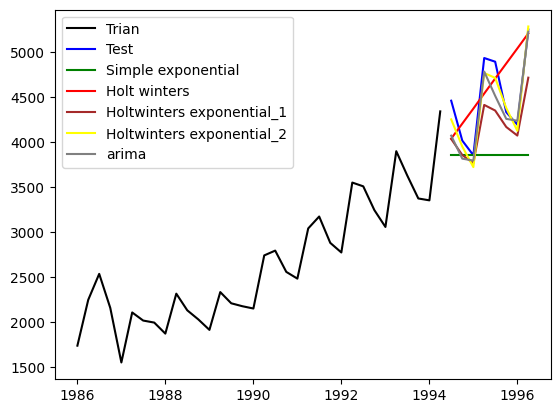

In [76]:
plt.plot(Train.index, Train.Sales, label='Trian', color='black')
plt.plot(Test.index, Test.Sales, label='Test', color='blue')
plt.plot(pred_ses.index, pred_ses, label='Simple exponential', color='green')
plt.plot(pred_hw.index, pred_hw, label='Holt winters', color='red')
plt.plot(pred_hwe_add_add.index, pred_hwe_add_add, label='Holtwinters exponential_1', color='brown')
plt.plot(pred_hwe_mul_add.index, pred_hwe_mul_add, label='Holtwinters exponential_2', color='yellow')
plt.plot(pred_test.index, pred_test, label='arima', color='grey')
#plt.plot(pred_sarima.index, pred_sarima, label='sarima', color='purple')
plt.legend(loc='best')

In [78]:
result={'MODEL':['Simple exponential','HOLT','holt winters_add_add','holt_winters_mul_mul','ARIMA','SARIMA'], 'RMSE':[rmse_ses, rmse_hw, rmse_hwe_add_add, rmse_hwe_mul_add, rmse_arima, rmse_sarima]}
result=pd.DataFrame(result)
result

,MODEL,RMSE
0,Simple exponential,786.835986
1,HOLT,459.775651
2,holt winters_add_add,372.754204
3,holt_winters_mul_mul,129.077482
4,ARIMA,215.186257
5,SARIMA,351.820396


In [ ]:
###Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend gave a least RMSE of 129.077

#model based

In [79]:
data.head()

,Quarter,Sales,datetime,quarter,year
datetime,,,,,
1986-01-01,Q1_86,1734.827000,1986-01-01,1,86
1986-04-01,Q2_86,2244.960999,1986-04-01,2,86
1986-07-01,Q3_86,2533.804993,1986-07-01,3,86
1986-10-01,Q4_86,2154.962997,1986-10-01,4,86
1987-01-01,Q1_87,1547.818996,1987-01-01,1,87


In [80]:
data=pd.get_dummies(data, columns=['quarter'])

In [81]:
data.head()

,Quarter,Sales,datetime,year,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,,,
1986-01-01,Q1_86,1734.827000,1986-01-01,86,1,0,0,0
1986-04-01,Q2_86,2244.960999,1986-04-01,86,0,1,0,0
1986-07-01,Q3_86,2533.804993,1986-07-01,86,0,0,1,0
1986-10-01,Q4_86,2154.962997,1986-10-01,86,0,0,0,1
1987-01-01,Q1_87,1547.818996,1987-01-01,87,1,0,0,0


In [82]:
data.shape

(42, 8)

In [83]:
data['t']=np.arange(1,43)

<Axes: xlabel='datetime'>

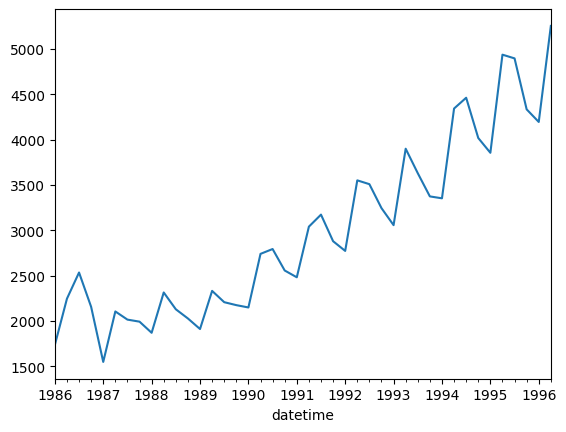

In [84]:
data['t_squared']=data['t']*data['t']
data['log_Sales']=np.log(data['Sales'])
data['Sales'].plot()


In [87]:
Train=data.head(34)
Test=data.tail(8)

In [88]:
data.head(1)

,Quarter,Sales,datetime,year,quarter_1,quarter_2,quarter_3,quarter_4,t,t_squared,log_Sales
datetime,,,,,,,,,,,
1986-01-01,Q1_86,1734.827,1986-01-01,86,1,0,0,0,1,1,7.458663


In [92]:
#LINEAR
import statsmodels.formula.api as smf
linear_model=smf.ols('Sales~t', data=Train).fit()
pred_linear=linear_model.predict(Test.t)
rmse_linear=RMSE(pred_linear, Test.Sales)
rmse_linear

720.6137817965266

In [93]:
#exponential
exp=smf.ols('log_Sales~t', data=Train).fit()
pred_exp=exp.predict(Test.t)
rmse_exp=RMSE(pred_exp, Test.Sales)
rmse_exp

4507.996475118845

In [94]:
##quadratic
quad=smf.ols('Sales~t+t_squared', data=Train).fit()
pred_quad=quad.predict(Test[['t','t_squared']])
rmse_quad=RMSE(pred_quad, Test.Sales)
rmse_quad

437.7455637558691

In [95]:
#additive seasonality
add_sea=smf.ols('Sales~ quarter_1+ quarter_2+ quarter_3+ quarter_4', data=Train).fit()
pred_add_sea= add_sea.predict(Test[['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']])
rmse_add_sea=RMSE(pred_add_sea, Test.Sales)
rmse_add_sea

1870.1899069853296

In [96]:
#additive seasonality quadratic
add_sea_quad=smf.ols('Sales~t+t_squared+ quarter_1+ quarter_2+ quarter_3+ quarter_4', data=Train).fit()
pred_add_sea_quad=add_sea_quad.predict(Test[['t','t_squared','quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']])
rmse_add_sea_quad=RMSE(pred_add_sea_quad, Test.Sales)
rmse_add_sea_quad

257.6717256536191

In [99]:
#Multiplicative seasonality
mul_sea=smf.ols('log_Sales~quarter_1+ quarter_2+ quarter_3+ quarter_4', data=Train).fit()
pred_mul_sea=mul_sea.predict(Test[['quarter_1','quarter_2','quarter_3','quarter_4']])
rmse_mul_sea=RMSE(pred_mul_sea, Test.Sales)
rmse_mul_sea

4508.457293546332

In [100]:
#multiplicative additive seasonality
mul_add_sea=smf.ols('log_Sales~t+quarter_1+ quarter_2+ quarter_3+ quarter_4', data=Train).fit()
pred_mul_add_sea=mul_add_sea.predict(Test[['t','quarter_1','quarter_2','quarter_3','quarter_4']])
rmse_mul_add_sea=RMSE(pred_mul_add_sea, Test.Sales)
rmse_mul_add_sea

4507.992090913164

In [101]:
results={'MODEL': ['linear','exponential','quadratic','additive seasonality','additive seasonality quadratic','Multiplicative seasonality','multiplicative additive seasonality'], 'RMSE': [rmse_linear, rmse_exp, rmse_quad,rmse_add_sea,rmse_add_sea_quad,
                                                                                                                                       rmse_mul_sea,rmse_mul_add_sea]}
results=pd.DataFrame(results)
results

,MODEL,RMSE
0,linear,720.613782
1,exponential,4507.996475
2,quadratic,437.745564
3,additive seasonality,1870.189907
4,additive seasonality quadratic,257.671726
5,Multiplicative seasonality,4508.457294
6,multiplicative additive seasonality,4507.992091


In [ ]:
# 4 dummy variables were created for quarter
# least RMSE of 257.671726 was obtained for the model additive seasonality quadratic
###Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend gave a least RMSE of 129.07
# therefore holts winter exponential smoothing will be used for Forecasting